# Hypermap BASTARD GAN PUNKS V2

<center>
<img src="https://sparklewerk.com/projects/hypermaps/bastards_plot_2.png?uncache_please" alt="demo hypermap" />
</center>

<br/>

<center>
<img src="https://sparklewerk.com/images/brands/sparklewerk/sparklewerk_wordmark.png" alt="Sparklewerk wordmark" align="center" />
<br/>
<br/>
<a href="https://colab.research.google.com/github/ManyHands/hypermap/blob/main/notebooks/hypermapping_bganpunks.ipynb" >
<img src="https://colab.research.google.com/assets/colab-badge.svg" width="20%"/>
</a>
</center>




## Introduction

This is a Jupyter notebook. The above "Open in Colab" button is how to run it for free.

This notebook hypermaps [the BASTARD GAN PUNKS V2 NFT collection](https://bastardganpunks.club/). For more information on hypermaps, please visit [sparklewerk.com](https://sparklewerk.com/projects/hypermaps).

This is free code running on free compute. If you are dissatisfied, we will have customer service get you a full refund. If on the other hand, you have constructive feedback please join the conversation on GitHub: [hypermap issues](https://github.com/ManyHands/hypermap/issues).

## License

Copyright (c) 2022, Many Hands SPC. All Rights Reserved.

Licensed under the MIT License (the "License");


In [ ]:
#@title Copyright (c) 2022, Many Hands SPC. All Rights Reserved.
#
# Licensed under the MIT License (the "License");
#
# MIT License
#
# Copyright (c) 2022, Many Hands SPC
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

## Set up

### Constants

All the configuration constants are defined first.


#### 2D plots

Computing the 2D renderings takes a few minutes. If you are only interested in the 3D, there is a switch to disable all the 2D compute.

In [ ]:
# The entire 2D rendering part of this can be disabled
render_2d_umap_plot_image = True

# How big to make the final Image the NFTs will be plotted into
# Twitter allows as big as (4096, 4096)
canvas_dimensions = (4096, 4096) # ((1024+512), (1024+512))

# How big to plot the bastards on that canvas
bastards_into_canvas_width = bastards_into_canvas_height = 128
bastards_into_canvas_size = (bastards_into_canvas_width, bastards_into_canvas_height)

#### UMAP input size

There are two constants that control how small the bastards will be resized to for processing. They start naturally as squares of (1024, 1024) end as squares of (X, X):
- `bastards_into_umap_width`: (int, int) for UMAP processing
- `bastards_into_projector_width`: (int, int) for Projector viz spritesheet


In [ ]:
bastards_into_umap_width = bastards_into_umap_height = 48
bastards_into_umap_size = (bastards_into_umap_width, bastards_into_umap_height)

#### Projector sprite size
By experimentation, it seems that for `bastards_into_projector_size`, (96, 96) is a decent downsampling size:

- (24, 24) is too small to see much detail. It does work but meh…
- (48, 48) kinda works but meh
- (64, 64) is a round size
- (96, 96) is too big for Projector

Although (96, 96) is a nice size (details show well), Projector refuses to accept a spritesheet that large. Largest it will accept is (8192, 8192) and (9600, 9600) for 10K would be too big.


In [ ]:
bastards_into_projector_witdth = bastards_into_projector_height = 64
bastards_into_projector_size = (bastards_into_projector_witdth, bastards_into_projector_height)

### Installs


In [ ]:
# TODO: there are ways to detect if umap-learn has already been installed. 
# Would make this a wee faster on repeat runs.
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 24.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=dd4964b5931f73d2df5780b97368f7e8ee880a18788d5c65a9a5e9ff520574bd
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=7984a60aaf1c7906588ba534d5b0dc12a4241f696ec34cfcdd552b19fa75e434
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


### Imports

In [ ]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import umap

from PIL import Image, ImageDraw
from math import trunc
from matplotlib import pyplot as plt
from numpy import asarray
from packaging import version
from skimage.color import rgb2gray

### TensorFlow set up

## GPU detection

At least one of the hypermapping algorithms, [UMAP](https://umap-learn.readthedocs.io/en/latest/), knows how to use server side GPUs and Colab provides such toys for free use.

In the menubar, select `Runtime→Change Runtime Type`, then
select GPU from the Hardware Accelerator drop-down


First, let's see if we have an Nvidia GPU.

In the following code cell, if the result is:
```
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver.
```
Then that means the Runtime is not set to GPU.

In [ ]:
!nvidia-smi

Sun Jan 23 04:35:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
try:
  # This tensorflow_version is a Colab-only thing
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print("TensorFlow version: ", tf.__version__)

assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

from tensorboard.plugins import projector
%load_ext tensorboard

# TODO: print tensorboard version?

tensorboard_data_dump_dir = '/content/tensorboard_data'
if not os.path.exists(tensorboard_data_dump_dir):
  os.makedirs(tensorboard_data_dump_dir)

TensorFlow version:  2.7.0


Not all GPUs on Colab are Nvidia models. So, the above may not have found an Nvidia GPU yet there may still be another manufacturers GPU. Here is how to check:

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data wrangling

The full bastards image collection can be found in the allbastards.com repo on GitHub.


### Inspect data

First let's make sure we're parsing the data correctly.

In [ ]:
# If repo has already been cloned, doing so again will error so let's not
if not os.path.isdir('allbastards.com'):
  !git clone https://github.com/rkalis/allbastards.com.git

Cloning into 'allbastards.com'...
remote: Enumerating objects: 86735, done.
remote: Counting objects: 100% (68397/68397), done.
remote: Compressing objects: 100% (11483/11483), done.
remote: Total 86735 (delta 57684), reused 67389 (delta 56910), pack-reused 18338
Receiving objects: 100% (86735/86735), 195.29 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (60855/60855), done.
Checking out files: 100% (22680/22680), done.


In [ ]:
!ls allbastards.com/public/img/full | wc -l

11306


In [ ]:
path, dirs, files = next(os.walk("allbastards.com/public/img/full"))
file_count = len(files)
print(file_count)
print(f'files[0] = "{files[0]}"')
print(f'Trimmed  = "{files[0][:-5]}"')

11306
files[0] = "3455.webp"
Trimmed  = "3455"


In [ ]:
def get_bastard_by_id(an_id: int):
  a_bastard = Image.open(os.path.join("allbastards.com/public/img/full",f'{an_id}.webp'))
  return a_bastard

The calmAF bastards (read: static webp files) are all (1024,1024)

In [ ]:
%%time 
# this can take about 15 seconds

calm_ids = []
hyped_ids = []

for file in files:
    a_bastard = Image.open(os.path.join("allbastards.com/public/img/full",file))
    if a_bastard.is_animated:
      hyped_ids.append(int(file[:-5]))
    else:
      calm_ids.append(int(file[:-5]))
                
print(f'calms: {len(calm_ids)}')
print(f'hypes: {len(hyped_ids)}')

calms: 10459
hypes: 847
CPU times: user 14.2 s, sys: 1.19 s, total: 15.4 s
Wall time: 15.3 s


Let's use Punk #42 as our poster child. And isn't he just a handsome boy?

size = ( 1024 , 1024 )
format =  WEBP
mode =  RGB


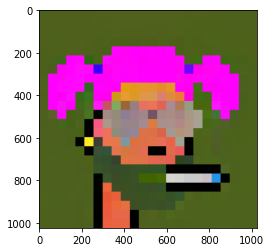

In [ ]:
a_bastard_filename = os.path.join('allbastards.com/public/img/full', '42.webp')
a_bastard = Image.open(a_bastard_filename) 

width, height = a_bastard.size
print('size = (', width, ',', height, ')')
print('format = ', a_bastard.format)
print('mode = ', a_bastard.mode)

plt.imshow(np.asarray(a_bastard))

Images of size (1024,1024) is 2 to the 10th. Mega. We need to downsample that before presenting the data to UMAP. And the bastards are color images (R,G,B) but UMAP wants simple scalors for values, so the color needs to be grayscaled. (Notice how the axis numbering changes.)

Downsampling to (48, 48)


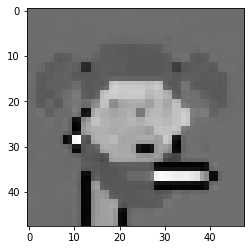

In [ ]:
print(f'Downsampling to {bastards_into_umap_size}')
a_bastard_downsized = a_bastard.resize(bastards_into_umap_size)
a_bastard_downsized_grayed = rgb2gray(np.asarray(a_bastard_downsized))

plt.imshow(a_bastard_downsized_grayed, interpolation='nearest', cmap='gray')
plt.show()

And then we flatten() the images to make them a sub-array of the 2D array to be presented to UMAP.

In [ ]:
print(a_bastard_downsized_grayed.flatten()[0])
print(a_bastard_downsized_grayed.flatten()[254])
print(type(a_bastard_downsized_grayed.flatten()[254]))

0.3425266666666667
0.34307725490196084
<class 'numpy.float64'>


Yup, that's the correct data type.

## UMAP

First we need to do the learning part, then once we have a trained model we embed and visualize the data.

### Vectorize data

Next we manipulate the data in prep for feeding it to UMAP.

We need to present all the bastards to Projector in the structure it wants, which is a 2D array. That array is a list of all the bastards to be projected. Each bastard has to be recast as a 1D feature vector, each feature a single number. So, each 2D image gets reshaped to a 1D array, and each color pixel (R,G,B) gets grayscaled to a single value.

In [ ]:
%%time
# This seems to take on Colab: ~2.5m

def load_calm_bastards_from_repo():
  # TODO: Surely there is some elegant pythonic way of doing this.

  # Just create the column names first, one for each pixel
  number_of_pixels = bastards_into_umap_width * bastards_into_umap_height
  feat_cols = [ 'pixel'+str(i) for i in range(number_of_pixels) ]

  calms_images = np.zeros((len(calm_ids), number_of_pixels))
  print(f'Shape of calm images: {calms_images.shape}')

  idx = 0
  for file in files:
    a_bastard = Image.open(os.path.join("allbastards.com/public/img/full",file))
    # TODO: let's get a progress bar going here. We do know how many files to process.
    if not a_bastard.is_animated:
      a_smaller_bastard = a_bastard.resize(bastards_into_umap_size)
      a_bastard_grayed = rgb2gray(asarray(a_smaller_bastard)) # This normalizes to [0..1]
      calms_images[idx] = a_bastard_grayed.flatten()
      idx = idx + 1
        
  return pd.DataFrame(calms_images,columns=feat_cols)

calms = load_calm_bastards_from_repo()

Shape of calm images: (10459, 2304)
CPU times: user 2min 17s, sys: 3.08 s, total: 2min 20s
Wall time: 2min 19s


In [ ]:
# Optionally, peek inside the DataFrame
calms

pixel0    pixel1    pixel2  ...  pixel2301  pixel2302  pixel2303
0      0.660536  0.660536  0.666147  ...   0.640897   0.640897   0.640897
1      0.078602  0.078602  0.078602  ...   0.076370   0.075537   0.075537
2      0.498535  0.309804  0.118528  ...   0.187339   0.207282   0.224137
3      0.249302  0.244198  0.239644  ...   0.191600   0.191600   0.191600
4      0.708238  0.708238  0.701794  ...   0.688660   0.688378   0.688378
...         ...       ...       ...  ...        ...        ...        ...
10454  0.771423  0.771423  0.771423  ...   0.775345   0.778150   0.778150
10455  0.455207  0.443763  0.435951  ...   0.322646   0.374551   0.416695
10456  0.668909  0.668909  0.668909  ...   0.671692   0.671692   0.671692
10457  0.236000  0.233738  0.230910  ...   0.235717   0.235717   0.235717
10458  0.877187  0.877187  0.877187  ...   0.877469   0.877469   0.877469

[10459 rows x 2304 columns]

### Visualize embedding

Note: we are not setting a random seed (See docs for [random_state](https://umap-learn.readthedocs.io/en/latest/reproducibility.html)). This way is faster. The plots will look different between runs though. But we are not aiming for reproducable science papers.


In [ ]:
def embed_data():
  return umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(calms)

In [ ]:
def show_simple_scatterplot(): 
  """
  Plots all bastards in 2D space as blue dots, no images
  """
  subset_of_embedding = embedding #[0:100] TODO: if want subsetting, need IDs for Projector
  fig = plt.figure(figsize=(15, 15))
  plt.scatter(subset_of_embedding[:,0], subset_of_embedding[:,1], s=1)
  plt.show()

So, what is the range of the X and Y values? Those are the bounding box of the plot.

[TODO: this should just be in the code. No manual calc'ing.]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


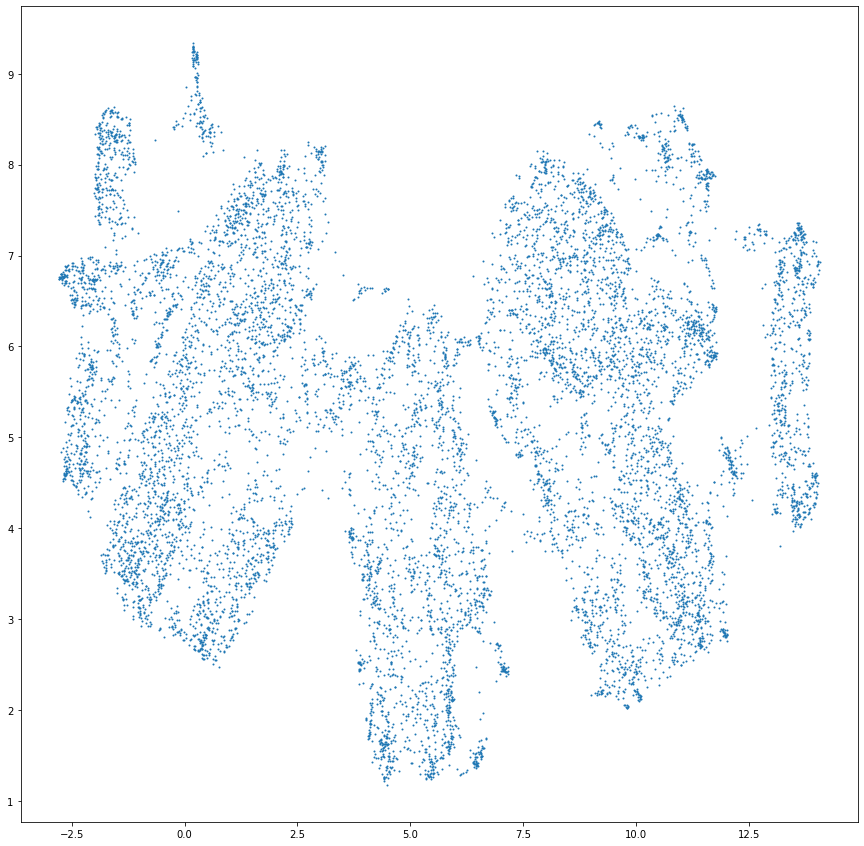

In [ ]:
if render_2d_umap_plot_image:
  embedding = embed_data()

  # print(type(embedding))
  # print('({}, {})'.format(np.min(embedding[:,0]), np.max(embedding[:,0])))
  # print('({}, {})'.format(np.min(embedding[:,1]), np.max(embedding[:,1])))
  
  show_simple_scatterplot()

#### 2D


In [35]:
def scatter_bastards_in_2d():
  canvas_dimensions = (2000, 2000)
  embedding_neighborhood = Image.new('RGBA', canvas_dimensions, (0,0,0,0))
  print(f'For rendering, down sampling to {bastards_into_projector_size}')

  print(f'type(embedding): {type(embedding)}')

  x_min = np.min(embedding[:,0])
  x_max = np.max(embedding[:,0])
  x_delta = x_max - x_min

  y_min = np.min(embedding[:,1]) 
  y_max = np.max(embedding[:,1])
  y_delta = y_max - y_min

  print(f'X: ({x_min}, {x_max})')
  print(f'Y: ({y_min}, {y_max})')

  idx = 0
  for file in files:
    a_bastard = Image.open(os.path.join("allbastards.com/public/img/full",file))
    if not a_bastard.is_animated:
      a_smaller_bastard = a_bastard.resize(bastards_into_projector_size)
      location = ( trunc((embedding[idx,0]+2)*132) , trunc((embedding[idx,1]+2)*132) )
      embedding_neighborhood.paste(a_smaller_bastard, location) #, mask=a_smaller_bastard)
      idx = idx + 1
  return embedding_neighborhood    


def generate_canvas():
  """
  Generate a vertical gradient.
  Via https://stackoverflow.com/a/63138452
  generate_gradient(colour1: str, colour2: str, width: int, height: int) -> Image:

  """
  color_top = '#66023c'
  color_bottom = '#0A0006'

  canvas = Image.new('RGB', canvas_dimensions, color_top)
  #base = Image.new('RGB', (width, height), colour1)
  top_coat = Image.new('RGB', canvas_dimensions, color_bottom)
  mask = Image.new('L', canvas_dimensions)
  mask_data = []
  for y in range(canvas_dimensions[0]):
    mask_data.extend([int(255 * (y / canvas_dimensions[1]))] * canvas_dimensions[0])
  mask.putdata(mask_data)
  canvas.paste(top_coat, (0, 0), mask)
  return canvas

def v2_scatter_bastards_in_2d():
  #canvas_dimensions = ((1024+512), (1024+512))
  canvas_width = canvas_dimensions[0]
  canvas_height = canvas_dimensions[1]

  x_min = np.min(embedding[:,0])
  x_max = np.max(embedding[:,0])
  x_delta = x_max - x_min
  x_factor = canvas_width / x_delta

  y_min = np.min(embedding[:,1]) 
  y_max = np.max(embedding[:,1])
  y_delta = y_max - y_min
  y_factor = canvas_height / y_delta

  print(f'X: ({x_min}, {x_max})')
  print(f'Y: ({y_min}, {y_max})')

  canvas = generate_canvas()

  def translate_to_canvas(x, y):
    pad_percentage = 0.075
    x_dest = trunc((x - x_min) * x_factor * (1 - (2*pad_percentage))) + trunc((pad_percentage * canvas_width))
    y_dest = trunc((y - y_min) * y_factor * (1 - (2*pad_percentage))) + trunc((pad_percentage * canvas_height))
    return (x_dest, y_dest)

  idx = 0
  # TODO: nasty, shouldn't be reading file again. weak
  for file in files:
    a_bastard = Image.open(os.path.join("allbastards.com/public/img/full",file))
    if not a_bastard.is_animated:
      a_smaller_bastard = a_bastard.resize(bastards_into_canvas_size)
      location = translate_to_canvas(embedding[idx,0], embedding[idx,1])
      canvas.paste(a_smaller_bastard, location) #, mask=a_smaller_bastard)
      idx = idx + 1

  return canvas


X: (-2.789775848388672, 14.061515808105469)
Y: (1.1763101816177368, 9.334168434143066)


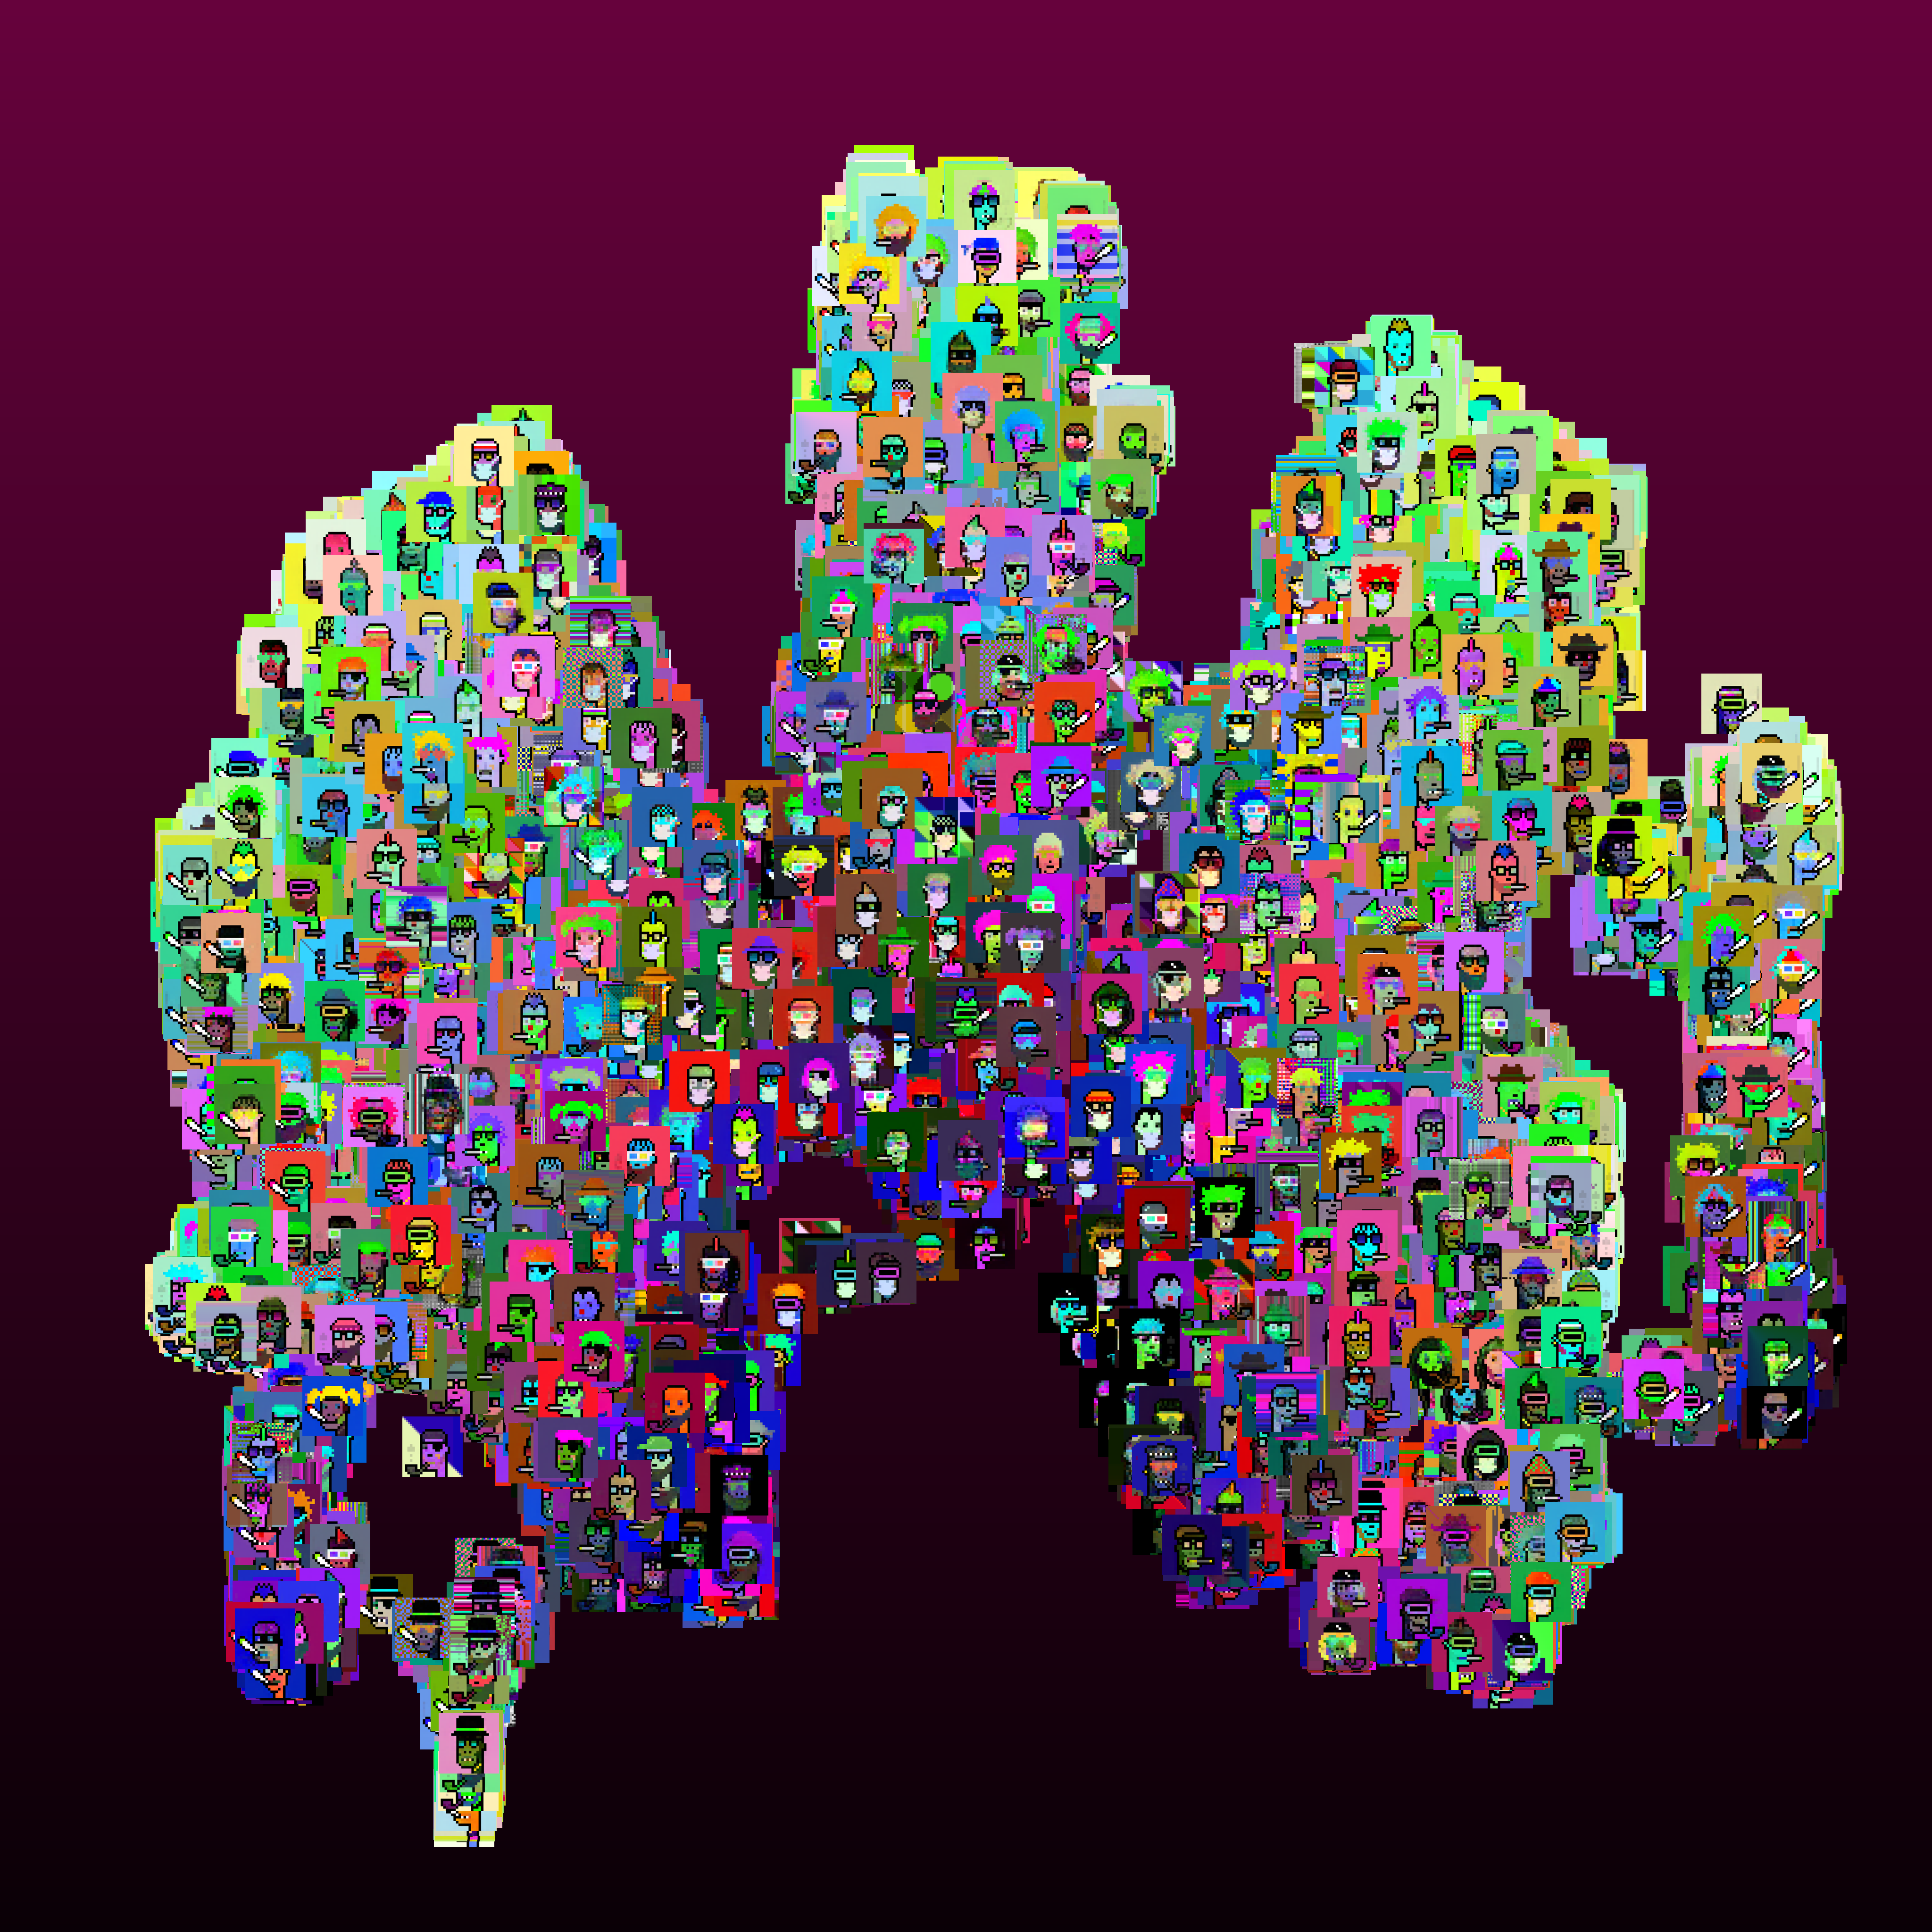

CPU times: user 2min 34s, sys: 4.58 s, total: 2min 39s
Wall time: 2min 38s


In [36]:
%%time
# This has been seen to take:
# At (64, 64): ~2.0m -- ~2.5m

if render_2d_umap_plot_image:
  scattered_bastards = v2_scatter_bastards_in_2d()
  display(scattered_bastards)

#### 3D

Next, feed the data into TensorBoard's Embedding Projector (or simply, Projector). 



##### Sprite sheet

To actually show the images floating in a 2D or 3D space, TensorBoard Projector requires a sprite sheet which contains a sprite for each image to be projected.

For now we're just using the calmAFs (static images), not the hypedAFs (animated GIFs). There are 10459 calms and 847 hypeds. The sprite sheet needs to be square, so let's just use the first 10000, for 100 x 100 sprite sheet. [TODO: plot all 10459 calms.]

The sprite sheet can be a PNG or a JPEG. (Not sure if an animated GIF will work in Projector.) So, for just-the-calms we'll go PNG.

In [ ]:
def create_sprite_sheet():
  spritesheet_square_length = 100 # 10,000 = 100 x 100 in spritesheet
  master_width = bastards_into_projector_witdth * spritesheet_square_length
  master_height = bastards_into_projector_witdth * spritesheet_square_length
  spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0) # fully transparent
  )

  # This CUT_OFF_LIMIT is a vile hack. Spritesheet must be square. Padding needed, but not now
  CUT_OFF_LIMIT = 10000 # TODO: remove this hack, sprite up ENTIRE collection

  punk_index = 0
  for x in range(CUT_OFF_LIMIT):
    a_punk = get_bastard_by_id(calm_ids[x]).resize(bastards_into_projector_size)
    div, mod = divmod(punk_index, spritesheet_square_length)
    h_loc = bastards_into_projector_witdth * div
    w_loc = bastards_into_projector_witdth * mod
    spriteimage.paste(a_punk, (w_loc, h_loc))
    punk_index = punk_index + 1

  return spriteimage

In [ ]:
%%time
# This cell has been seen to take ~2min for (128, 128)

def write_files_for_tensorboard():
  # First, generate spritesheet for Projector to use downsammpled sprites
  sprite_sheet = create_sprite_sheet()
  sprite_filename = os.path.join(tensorboard_data_dump_dir, 'embeddings/sprite.png')
  if not os.path.exists(os.path.dirname(sprite_filename)):
    os.makedirs(os.path.dirname(sprite_filename))
  sprite_sheet.save(sprite_filename)

  # Next the data for the dimensionality reducers (UMAP, t-SNE, PCA) to crunch on
  vectorized_punks = tf.Variable(calms[0:9999])
  checkpoint = tf.train.Checkpoint(embedding=vectorized_punks)
  checkpoint.save(os.path.join(tensorboard_data_dump_dir, 'embedding.ckpt'))


  config = projector.ProjectorConfig()
  embedder = config.embeddings.add()

  embedder.tensor_name = 'embedding/.ATTRIBUTES/VARIABLE_VALUE'

  embedder.sprite.image_path = sprite_filename
  embedder.sprite.single_image_dim.extend(bastards_into_projector_size)

  projector.visualize_embeddings(tensorboard_data_dump_dir, config)

write_files_for_tensorboard()

**Bug in TensorBoard launch**

**NOTE:** TensorBoard regularly fails to find the data just written to the file system. If so just rerun the following cell; that usually gets it to wake up and get to work.

Also note that:
- "Fetching tensor values…" normally takes a minute or two
- "Fetching sprite image…" normally takes a minute
- Then PCA will run automatically
- When PCA is done, click on UMAP or tSNE for other hypermap algorithms that will each provide a different view of the collection.

☝ ↑ ☝ ↑ ☝ ↑ ☝ ↑ ☝ ↑ ☝ 

In [ ]:
# If this results in "No datasets found" then simply rerun this cell

%reload_ext tensorboard
%tensorboard --logdir={tensorboard_data_dump_dir}

# If this results in "No datasets found" then simply rerun this cell

# TODO: errors seen that need to be worked out
# - "Error parsing tensor bytes" 
# - "Error parsing tensor bytes RangeError: byte length of Float32Array should be a multiple of 4"

**History:**
- v1.0.1 (2022-01-11, John Tigue): 
  - Added Intro text
- v1.0.2 (2022-01-20, John Tigue): 
  - UMAP'ed at (48px, 48px)
  - Projected at (64px, 64px) 
- v1.0.3 (2022-01-21, John Tigue):
  - UMAP to 2D at (128,128) on (4096, 4096) for Twitter
  - Add gradient background
  - Add labeling
